[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KitchinHUB/si-dynamic-catalysis-1/blob/master/Optimization/7-Single_Gaussian_pulse_optimization_IPOPT.ipynb)

# Notebook #7: Pyomo/IPOPT optimization for the single Gaussian pulse

This Jupyter Notebook is part of the Supporting Information for the paper *Cyclic steady state simulation and waveform design for Dynamic/Programmable Catalysis*, by C. C. Tedesco, J. R. Kitchin, and C. D. Laird.

This notebook contains the code to perform the optimization of a Gaussian pulse function as a forcing signal for dynamic catalysis. The optimization framework is built with Pyomo.DAE [[1]](#1) and IPOPT [[2]](#2) solves for the degrees of freedom. This is a different approach than what is presented in Notebook #5.

Please see following code, comments and narrative text to understand and use the workflow.

## Install Pyomo and IPOPT on Google Colab

In [1]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'

!pip install munch 

## Importing packages

In [1]:
from munch import Munch
import numpy as np
from pyomo.environ import (ConcreteModel, Constraint, Objective, Var, NonNegativeReals, Param,
                           SolverFactory, value, sin, cos, exp, atan, Set, maximize, value,
                           TransformationFactory, assert_optimal_termination, RangeSet)
from pyomo.dae import ContinuousSet, DerivativeVar
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
import pandas as pd
from scipy import signal
from tqdm import tqdm 
import idaes
import time

## Declaring parameters values


In [2]:
class Params:
    """
    Declares reaction system and CSTR model parameters
    """
    
    def __init__(self,  T = 423.15, # K
                        q = 0.0008333, # L/s
                        Po = 1.01325, # bar
                        Rg_constants = 0.0083144626, # kJ/K-gmol
                        Rg_Caf = 0.083144626, # bar-L/K-gmol
                        Rg_ODEs = 0.083144626, # bar-L/K-gmol
                        kB = 1.380649e-23, # J/K
                        hp = 6.62607015e-34, # J-s
                        F = 96.485, # mC/gmol
                        alpha = 0.6, 
                        beta = 100,
                        gamma = 2, 
                        delta = 1.4, # eV
                        H1 = 0, # kJ/mol
                        H2 = 0, # kJ/mol
                        N = 2.76e-6, # gmol sites
                        V = 2.60e-4, # L
                        Caf = 2.8423101747069843, # mol/L
                        Cbf = 0, # mol/L
                        delS1 = -135, # J/mol-K
                        delS2 = 0, # J/mol-K
                        delS3 = 135, # J/mol-K
                        number_periods = 1,
                        ):
        
        
        self.T = T # Temperature on the simulated CSTR
        self.Po = Po # Standard pressure
        self.Caf = Caf # Initial concentration of A
        self.Cbf = Cbf # Initial concentration of B
        self.Rg_constants  = Rg_constants # Gas constant used in kinetic constants calculation
        self.Rg_Caf = Rg_Caf # Gas constant used to calculate Caf
        self.Rg_ODEs = Rg_ODEs # Gas constant used in the ODEs
        self.kB = kB # Boltzmann constant
        self.hp = hp # Plank constant
        self.F = F  # Faraday constant, for unit conversion
        self.alpha = alpha # Parameter for the BEP relation, slope of line of the relashionship
        self.beta = beta # Parameter for the BEP relation, intercept of line of the relashionship
        self.gamma = gamma # Parameter for the BE relation, slope of line of the relashionship
        self.delta = delta # Parameter for the BE relation, common BE point
        self.H1 = H1 # Enthalpy of A
        self.H2 = H2 # Enthalpy of B
        self.V = V # Volume of the CSTR
        self.delS1 = delS1 # Entropy of A
        self.delS2 = delS2 # Entropy of reaction
        self.delS3 = delS3 # Entropy of B
        self.q = q # Volumetric rate of the reactor
        self.N = N # Number of active sites on the surface
        self.number_periods = number_periods # Number of periods to be simulated 

In [3]:
def rate_constants(params, t):
    """
    Function to calculate the rate constants that do not change over time (adsorption)
    """
    
    T = params.T
    Rg_constants = params.Rg_constants
    kB = params.kB
    hp = params.hp
    delS1 = params.delS1
    delS2 = params.delS2
    delS3 = params.delS3

    # Here we only calculate the 2 kinetic constants that do not depend on time
    kf1 = (kB * T / hp) * exp(delS1 * 0.001 / Rg_constants) # A(g) + * --> A*
    kr3 = (kB * T / hp) * exp(-delS3 * 0.001 / Rg_constants) # B(g) + * --> B*

    return Munch(kf1 = kf1, kr3 = kr3) 

## Creating the pyomo model


In [4]:
def create_pyomo_model(params):
    """
    Create the pyomo model for the CSTR. Calls the discretization through Backwards Finite Difference 
    as a means to solve the ODE system modelled here. 
    
    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"
        tfinal: period of the wave, calculated from the optimal frequency value

    Returns:
        Discretized Pyomo model
    """
        
    T = params.T
    q = params.q
    Po = params.Po
    Caf = params.Caf
    Cbf = params.Cbf
    Rg_constants = params.Rg_constants
    Rg_Caf = params.Rg_Caf
    Rg_ODEs = params.Rg_ODEs
    kB = params.kB
    hp = params.hp
    F = params.F
    alpha = params.alpha
    beta = params.beta
    gamma = params.gamma
    delta = params.delta
    H1 = params.H1
    H2 = params.H2
    N = params.N
    V = params.V
    delS1 = params.delS1
    delS2 = params.delS2
    delS3 = params.delS3
    number_periods = params.number_periods
    nfe = params.nfe
    
    # Create Pyomo model and parameters
    m = ConcreteModel()
    m.params = params
    
    # Create time span
    # Scaling time to be between 0 and 1 
    m.tau = ContinuousSet(bounds = (0, 1)) 
    # True time span, dependent of tau
    m.times = Var(m.tau) 
    
    # Define variables- concentrations varying with time, 
    # initialized in values that would make sense to be the solution
    m.Ca = Var(m.tau, bounds=(0,None), initialize=2.84)
    m.Cb = Var(m.tau, bounds=(0,None), initialize=0.1)
    m.thetaA = Var(m.tau, bounds=(0,1), initialize=0.5)
    m.thetaB = Var(m.tau, bounds=(0,1), initialize=0.5)

    # Declare derivative variables
    m.dtimedtau = DerivativeVar(m.times)
    m.dCadt = DerivativeVar(m.Ca)
    m.dCbdt = DerivativeVar(m.Cb)
    m.dthetaAdt = DerivativeVar(m.thetaA)
    m.dthetaBdt = DerivativeVar(m.thetaB)
    
    # Declare new variables- solved with the optimization
    m.avTOF = Var(within = NonNegativeReals, initialize = 800)
    m.BEa = Var(m.tau, within = NonNegativeReals, initialize = 1.7)
    m.BEb = Var(m.tau, within = NonNegativeReals, initialize = 1.1)
    m.kf2 = Var(m.tau, within = NonNegativeReals, initialize = 500)
    m.kf3 = Var(m.tau, within = NonNegativeReals, initialize = 1.3e-11)
    m.kr1 = Var(m.tau, within = NonNegativeReals, initialize = 5e-8)
    m.kr2 = Var(m.tau, within = NonNegativeReals, initialize = 0.084)
    m.amplitude = Var(bounds = (0.1, 0.4), initialize = 0.2)
    m.offset = Var(bounds = (1, 2), initialize = 1.2)
    m.center_freq = Var(bounds = (0.01, 0.07), initialize = 0.03)
    m.freq_osci = Var(bounds = (500, 1500), initialize = 1000)
    m.tf = Var(within = NonNegativeReals, initialize = 0.001)
    m.pulse_position = Param(initialize = 0.5) 
    
    # Constraint that says dtime/dtau = final time, since time = tau * final time
    @m.Constraint(m.tau)
    def _ode3(m,t):
        if t == 0:
            return Constraint.Skip
        return m.dtimedtau[t] == m.tf
    
    # Constraint that associates the one-period simulation with the final time
    @m.Constraint()
    def tfinal_constraint(m):
        return m.tf == params.number_periods * 1 / m.freq_osci
    
    
    # Declare binding energy variation as constraints 
    
    @m.Constraint(m.tau)
    def BEA_constraint(m, t):
        # Binding energy (eV)- oscillates with a periodic gaussian pulse
        return m.BEa[t] == -2 * m.amplitude * \
               exp(-((t - m.pulse_position) / (2 * m.center_freq))**2) + m.offset

    
    @m.Constraint(m.tau)
    def BEB_constraint(m, t):
        pt = rate_constants(m.params, t)
        return m.BEb[t] == params.gamma * m.BEa[t] + (1 - params.gamma) * params.delta 
    
    # Declare kinetic constants equations as constraints
    @m.Constraint(m.tau)
    def kf2_constraint(m, t):
        pt = rate_constants(m.params, t)
        return m.kf2[t] == ((params.kB * params.T) / hp) * exp(-(params.alpha * \
                ((params.H2 - (params.gamma * m.BEa[t] + params.H2 / params.F - params.gamma * params.H1 / params.F \
                + (1 - params.gamma) * params.delta) * params.F) - (params.H1 - m.BEa[t] * F)) \
                + params.beta) / params.Rg_constants / params.T)
    
    @m.Constraint(m.tau)
    def kf3_constraint(m, t):
        pt = rate_constants(m.params, t)
        return m.kf3[t] ==  pt.kr3 * (exp(-(((params.gamma * m.BEa[t] + params.H2 / params.F \
                - params.gamma * params.H1 / params.F + (1 - params.gamma) * params.delta) * params.F) \
                - params.T * params.delS3 * 0.001) / params.Rg_constants / T))

    @m.Constraint(m.tau)
    def kr1_constraint(m, t):
        pt = rate_constants(m.params, t)
        return m.kr1[t] == pt.kf1/(exp(-((-m.BEa[t] * params.F) \
                - params.T * params.delS1*0.001) / params.Rg_constants/params.T))
    
    @m.Constraint(m.tau)
    def kr2_constraint(m, t):
        pt = rate_constants(m.params, t)
        return m.kr2[t] == m.kf2[t] / (exp(-(((params.H2 - (params.gamma*m.BEa[t] + params.H2 / params.F \
                - params.gamma * params.H1 / params.F \
                + (1 - params.gamma) * params.delta) * params.F) - (params.H1 - m.BEa[t]  *params.F))\
                - params.T  *params.delS2 * 0.001) / params.Rg_constants / params.T))
    
    @m.Constraint(m.tau)
    # Define equation that is a function of the model and t
    def dCadt_eq(m,t):
        # pt gets the result of the function 
        pt = rate_constants(m.params, t)
        # Declare theta_star since it varies with thetaA and B and therefore, with time
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        # ODE, being that `munch` format was used to get the k's from the function
        # Multiply the final time for time scaling
        return m.dCadt[t] == m.tf * ((params.q / params.V) * (params.Caf - m.Ca[t]) \
                - pt.kf1 * m.Ca[t] * params.Rg_ODEs * params.T * (theta_star) / params.Po * (params.N / params.V) \
                + m.kr1[t] * m.thetaA[t] * (params.N / params.V))
    
    @m.Constraint(m.tau)
    def dCbdt_eq(m,t):
        pt = rate_constants(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return m.dCbdt[t] == m.tf * ((params.q/params.V) * (params.Cbf - m.Cb[t]) \
            + (m.kf3[t] * m.thetaB[t] - pt.kr3 * m.Cb[t] * params.Rg_ODEs * params.T * (theta_star) / params.Po)\
            * (params.N / params.V))

    @m.Constraint(m.tau)
    def dthetaAdt_eq(m,t):
        pt = rate_constants(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return  m.dthetaAdt[t] == m.tf * (pt.kf1 * m.Ca[t] * params.Rg_ODEs * params.T * (theta_star) / params.Po \
            - m.kr1[t] * m.thetaA[t] - m.kf2[t] * m.thetaA[t] + m.kr2[t] * m.thetaB[t])
    
    @m.Constraint(m.tau)
    def dthetaBdt_eq(m,t):
        pt = rate_constants(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return m.dthetaBdt[t] == m.tf * ((m.kf2[t] * m.thetaA[t] - m.kr2[t] * m.thetaB[t]) \
            - (m.kf3[t] * m.thetaB[t] - pt.kr3 * m.Cb[t] * Rg_ODEs * T * (theta_star) / Po))
    
    # Declare discretization method and parameters 
    discretizer = TransformationFactory('dae.finite_difference')
    discretizer.apply_to(m, nfe = nfe, scheme='BACKWARD')
    
    # Return the model
    return m

## Building the optimization problem


In [5]:
params = Params()
params.nfe = 900

m = create_pyomo_model(params)

m.TOF_constraint = Constraint(expr = m.avTOF == ((sum(m.Cb[t] for t in m.times)) \
                                                 * params.q / params.N) / (params.nfe + 1))

# objective function          
m.obj = Objective(expr = m.avTOF, sense = maximize)

# Equality constraints for initial and final points
m.CaCSS = Constraint(expr= m.Ca[m.tau.first()] == m.Ca[m.tau.last()])
m.CbCSS = Constraint(expr= m.Cb[m.tau.first()] == m.Cb[m.tau.last()])
m.thetaACSS = Constraint(expr= m.thetaA[m.tau.first()] == m.thetaA[m.tau.last()])
m.thetaBCSS = Constraint(expr= m.thetaB[m.tau.first()] == m.thetaB[m.tau.last()])

start_time = time.time()

solver = SolverFactory('ipopt')
status = solver.solve(m, tee = True)
assert_optimal_termination(status)
 
end_time = time.time()
elapsed_time = end_time - start_time

print(f'Result given in {elapsed_time} s.')

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

  64 -7.2601366e+02 3.39e+04 2.48e+06  -2.5 1.42e+05 -10.6 1.78e-01 1.00e+00h  1
  65 -7.2603677e+02 3.39e+04 2.49e+06  -2.5 3.68e+03  -4.7 4.81e-02 2.78e-04h  1
  66 -7.2287389e+02 1.81e+03 1.35e+03  -2.5 6.35e+01  -5.2 1.00e+00 1.00e+00h  1
  67 -7.2291231e+02 5.97e+00 6.79e+00  -2.5 1.33e+01  -5.7 1.00e+00 1.00e+00h  1
  68 -7.2350999e+02 2.22e-01 1.16e+01  -2.5 3.95e+01  -6.2 1.00e+00 1.00e+00h  1
  69 -7.2508615e+02 1.63e+00 7.99e+01  -2.5 1.08e+02  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -7.2564652e+02 1.60e+00 4.70e+03  -2.5 2.51e+02  -7.1 1.00e+00 1.67e-01h  1
  71 -7.2579476e+02 2.15e+00 5.41e+00  -2.5 6.10e+02  -7.6 1.00e+00 1.00e+00h  1
  72 -7.2662152e+02 1.86e+01 1.32e+01  -2.5 1.80e+03  -8.1 1.00e+00 1.00e+00h  1
  73 -7.2873559e+02 1.50e+02 1.11e+02  -2.5 5.09e+03  -8.6 1.00e+00 1.00e+00h  1
  74 -7.3388285e+02 9.40e+02 3.35e+04  -2.5 1.28e+04  -9.0 7.29e-01 1.00e+00h  1
  75 -7.4300747e+02 1.59e+03

 155 -8.1062865e+02 1.12e-07 1.47e-09  -9.0 1.10e-02 -19.1 1.00e+00 1.00e+00h  1
 156 -8.1062865e+02 2.14e-08 6.28e-10  -9.0 1.10e-02 -18.7 1.00e+00 1.00e+00h  1
 157 -8.1062865e+02 7.92e-09 5.41e-09  -9.0 2.13e-05 -19.1 1.00e+00 7.81e-03h  8

Number of Iterations....: 157

                                   (scaled)                 (unscaled)
Objective...............:  -8.1062864731892819e+02   -8.1062864731892819e+02
Dual infeasibility......:   5.4087649914436042e-09    5.4087649914436042e-09
Constraint violation....:   7.9162418842315674e-09    7.9162418842315674e-09
Complementarity.........:   9.0909386343260551e-10    9.0909386343260551e-10
Overall NLP error.......:   7.9162418842315674e-09    7.9162418842315674e-09


Number of objective function evaluations             = 374
Number of objective gradient evaluations             = 158
Number of equality constraint evaluations            = 374
Number of inequality constraint evaluations          = 0
Number of equality constraint Jac

In [9]:
opt_avTOF = value(m.obj)

print(f'The optimal point found is with'
      f' amplitude = {m.amplitude():1.2f} eV, frequency = {m.freq_osci()} Hz, \
center frequency (width) of {m.center_freq():1.2e}, offset = {m.offset():1.2f} eV, \
resulting in a time-averaged TOF = {opt_avTOF:1.2f} Hz. The result is given in {elapsed_time:.2f} seconds.')

The optimal point found is with amplitude = 0.40 eV, frequency = 1500.0 Hz, center frequency (width) of 3.43e-02, offset = 1.77 eV, resulting in a time-averaged TOF = 810.63 Hz. The result is given in 1756.25 seconds.


## Printing results and plots

In [7]:
# Attributing arrays for plotting
Ca = [value(m.Ca[t]) for t in m.times]
Cb = np.asarray([value(m.Cb[t]) for t in m.times])
thetaA = [value(m.thetaA[t]) for t in m.times]
thetaB = [value(m.thetaB[t]) for t in m.times]
theta_star = [value(1 - m.thetaA[t] - m.thetaB[t]) for t in m.times]

BEa = [value(m.BEa[t]) for t in m.times]

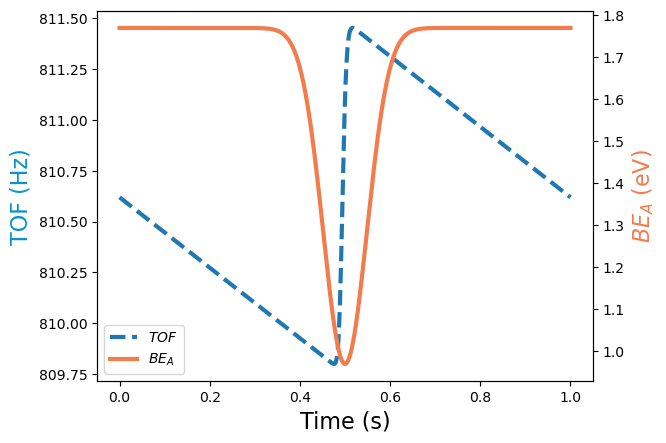

In [8]:
# Creating the two plots in the same frame
fig, ax1 = plt.subplots()

TOF = Cb*params.q/params.N

# Creating the first plot: times x TOF plot
ax1.plot(m.tau, TOF, label='$TOF$', linewidth=3, linestyle ='--')
ax1.set_ylabel('TOF (Hz)', color ='#0892d0', fontsize=16)
ax1.set_xlabel('Time (s)', fontsize=16)

# Creating the second plot: times x BEa with axes on the right side
ax2 = ax1.twinx()
ax2.plot(m.tau, BEa, label='$BE_A$', color='#f37c4c', linewidth=3)
ax2.set_ylabel('$BE_A$ (eV)', color='#f37c4c', fontsize=16)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower left');

## Bibliography

<a id="1">1. B. Nicholson, J. D. Siirola, J. Watson, V. M. Zavala, and L. T. Biegler. pyomo.dae: a mod-
eling and automatic discretization framework for optimization with differential and algebraic
equations. Mathematical Programming Computation, 10(2):187–223, 2018.
    
<a id="2">2. A. W achter and L. Biegler. On the implementation of an interior-point filter line-search
algorithm for large-scale nonlinear programming. Mathematical Programming, 106:25–57, 2006.